In [311]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lars_path

import afinn
import re

%matplotlib inline
sns.set()

In [312]:
with open('video_channel_df_5785_fin.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [313]:
df.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'video_age_min',
       'likes', 'dislikes', 'video_desc_length', 'subscriber_count',
       'total_views_channel', 'n_featured_channels', 'n_promo_links',
       'channel_desc_length', 'channel_age_days', 'video_age_days',
       'delivery_method_Published', 'delivery_method_Streamed live',
       'sentiment_score_channel_desc', 'sentiment_score_video_desc',
       'channel_URL', 'channel_name'],
      dtype='object')

In [314]:
X = df.loc[:,'video_order_num':'sentiment_score_video_desc'].values.reshape(-1, 1)
y = df['views_video']

## Baseline linear regression

In [315]:
X_train, X_test, y_train, y_test = train_test_split(df[['video_order_num', 'duration_sec', 'video_age_min',
       'likes', 'dislikes', 'video_desc_length', 'subscriber_count',
       'total_views_channel', 'n_featured_channels', 'n_promo_links',
       'channel_desc_length', 'channel_age_days', 'video_age_days',
       'delivery_method_Published', 'delivery_method_Streamed live',
       'sentiment_score_channel_desc', 'sentiment_score_video_desc']], 
                                                    df['views_video'], test_size=0.33, random_state=42)
vanilla_LR = LinearRegression()
vanilla_LR.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [316]:
vanilla_LR.score(X_train,y_train) #--> outliers

0.8142919598289304

In [317]:
vanilla_LR.score(X_test,y_test)

0.8602084279820329

## Remove outliers

In [318]:
df['res'] = abs(vanilla_LR.predict(df[['video_order_num', 'duration_sec', 'video_age_min',
       'likes', 'dislikes', 'video_desc_length', 'subscriber_count',
       'total_views_channel', 'n_featured_channels', 'n_promo_links',
       'channel_desc_length', 'channel_age_days', 'video_age_days',
       'delivery_method_Published', 'delivery_method_Streamed live',
       'sentiment_score_channel_desc', 'sentiment_score_video_desc']])-df['views_video'])

In [319]:
df['res'].describe()

count    5.785000e+03
mean     1.881464e+05
std      1.644165e+06
min      2.049831e+01
25%      3.618137e+04
50%      7.356019e+04
75%      1.233987e+05
max      9.141757e+07
Name: res, dtype: float64

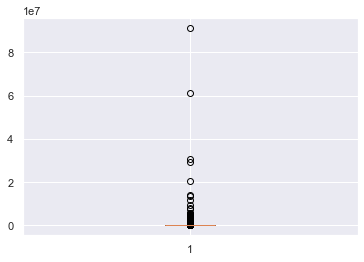

In [320]:
plt.boxplot(df['res']);

In [321]:
#outliers in terms of residuals
df[df['res'] > 1.233987e+05]

,views_video,video_order_num,duration_sec,video_age_min,likes,dislikes,video_desc_length,subscriber_count,total_views_channel,n_featured_channels,...,channel_desc_length,channel_age_days,video_age_days,delivery_method_Published,delivery_method_Streamed live,sentiment_score_channel_desc,sentiment_score_video_desc,channel_URL,channel_name,res
video_id,,,,,,,,,,,,,,,,,,,,,
c8RrUCDu6RU,10874.0,21.0,2100.0,63072000.0,15.0,1.0,574.0,3020.0,237248.0,0.0,...,288.0,4426.0,1645.0,0,1,11.0,-2.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,206084.356027
wwYaE2YVeWM,13504.0,23.0,1740.0,63072000.0,18.0,0.0,530.0,3020.0,237248.0,0.0,...,288.0,4426.0,1693.0,0,1,11.0,-1.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,227601.287310
-U5LaNdDVO4,10134.0,22.0,2700.0,63072000.0,19.0,0.0,1111.0,3020.0,237248.0,0.0,...,288.0,4426.0,1659.0,0,1,11.0,1.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,225847.928078
cRkp5_w9JLM,21721.0,9.0,444.0,15768000.0,667.0,0.0,513.0,3020.0,237248.0,0.0,...,288.0,4426.0,637.0,1,0,11.0,17.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,509179.833162
2bmF9Ms2ihI,812210.0,4.0,2520.0,432000.0,140.0,2.0,810.0,3020.0,237248.0,0.0,...,288.0,4426.0,306.0,1,0,11.0,8.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,601971.030324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XxMsRv1eCoI,936724.0,2.0,60.0,63072000.0,302.0,44.0,859.0,22700.0,4556575.0,1.0,...,329.0,2989.0,1619.0,1,0,6.0,0.0,https://www.youtube.com/user/onlymyhealthyoga,Onlymyhealth Yoga,422980.464859
yiVrlfljeL8,26284.0,4.0,60.0,63072000.0,26.0,0.0,849.0,22700.0,4556575.0,1.0,...,329.0,2989.0,1620.0,1,0,6.0,0.0,https://www.youtube.com/user/onlymyhealthyoga,Onlymyhealth Yoga,126997.380153
sH8iWAs49F8,438424.0,5.0,60.0,63072000.0,82.0,13.0,914.0,22700.0,4556575.0,1.0,...,329.0,2989.0,1621.0,1,0,6.0,0.0,https://www.youtube.com/user/onlymyhealthyoga,Onlymyhealth Yoga,194685.960834


In [324]:
df_no_outliers = df[df['res'] < 1.233987e+05]  ## keep 6

In [325]:
df_no_outliers.shape ##removed 99 observations with greatest residual values 

(4338, 21)

## Baseline Regression with Outliers Removed

In [326]:
X_train, X_test, y_train, y_test = train_test_split(df_no_outliers[['video_order_num', 'duration_sec', 'video_age_min',
       'likes', 'dislikes', 'video_desc_length', 'subscriber_count',
       'total_views_channel', 'n_featured_channels', 'n_promo_links',
       'channel_desc_length', 'channel_age_days', 'video_age_days',
       'delivery_method_Published', 'delivery_method_Streamed live',
       'sentiment_score_channel_desc', 'sentiment_score_video_desc']], 
                                                    df_no_outliers['views_video'], test_size=0.33, random_state=42)

In [327]:
vanilla_LR_no = LinearRegression()
vanilla_LR_no.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [328]:
vanilla_LR_no.score(X_train,y_train) #--> outliers

0.9402782673152703

In [329]:
vanilla_LR_no.score(X_test,y_test)

0.9252298628276817

## Regularizing, keeping Original Features

In [330]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray

In [331]:
alphavec = 10**np.linspace(-6,4,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train);

In [332]:
lasso_model.score(X_tr,y_train)

0.9402782673152703

In [333]:
lasso_model.alpha_

1e-06

In [334]:
lasso_model.score(X_te,y_test) ##doesnt work

0.9252298628257376

## Feature Engineering

Polynomial

In [335]:
pf = PolynomialFeatures(degree=2)

In [336]:
orig_features = ['video_order_num', 'duration_sec', 'video_age_min',
       'likes', 'dislikes', 'video_desc_length', 'subscriber_count',
       'total_views_channel', 'n_featured_channels', 'n_promo_links',
       'channel_desc_length', 'channel_age_days', 'video_age_days',
       'delivery_method_Published', 'delivery_method_Streamed live',
       'sentiment_score_channel_desc', 'sentiment_score_video_desc']
pf.fit(df_no_outliers[orig_features])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [337]:
feat_array = pf.transform(df_no_outliers[orig_features])
#feat_array = pd.DataFrame(feat_array, columns = pf.get_feature_names(input_features=orig_features))

In [338]:
y = df_no_outliers['views_video']

In [339]:
X_train, X_test, y_train, y_test = train_test_split(feat_array, y, test_size=0.33, random_state=42)
model_w_poly_feat = LinearRegression()
model_w_poly_feat.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [340]:
model_w_poly_feat.score(X_train,y_train)

0.962094156090878

In [341]:
model_w_poly_feat.score(X_test,y_test)

0.8603719342710913

In [342]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(-6,4,200)
lasso_model_w_poly_feat = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat.fit(X_tr, y_train);

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4513597893.324463, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5333686776.226318, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6916880111.926025, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 349414576384.2418, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 353493257529.74664, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357179365583.5746, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390612555685.61, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390797676500.55145, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390953156558.1572, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390840635827.67847, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390809079965.1728, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390777663529.5745, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390111187936.67896, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390090987236.51624, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 390071113617.2802, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8266012654.215454, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12288858610.947754, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15033685810.214111, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 293611506982.90936, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 301795713051.912, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 309712931412.51404, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368463183471.2197, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368624225803.2905, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 368754867301.84595, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367941872336.6146, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367875400247.47046, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 367810098580.97516, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366446411626.02814, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366426643705.4129, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366407649132.0583, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7588443837.569214, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8280648261.512939, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7098922507.642822, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267613776702.27716, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 274401990806.50592, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 281382512210.07965, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344989655363.55865, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345160831359.2267, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345303928712.0414, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345094652588.17505, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345049585871.70135, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 345005025789.06537, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344124874148.69275, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344104127573.6116, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344084072955.30756, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343739261983.0417, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343731763233.23584, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343724525866.1074, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298422609996.6406, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 303440787299.60815, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 307978494597.04706, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347818282803.8236, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 347973655863.4961, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348112111035.65594, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348390861294.9421, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348375332921.05566, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348360260959.5883, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348108736930.2138, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348105604060.96106, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 348102650817.2356, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14256551681.45288, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25512356980.697998, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47580816940.984985, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarni

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 334995400654.6416, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 337623650473.8356, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 339992483600.32733, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarnin

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357158185662.3409, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357139149395.51587, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 357113221230.1478, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarnin

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355571762429.85583, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355526987955.26105, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 355483314636.68677, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarn

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354608316956.011, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354591897440.1863, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 354575999716.6981, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning:

In [343]:
lasso_model_w_poly_feat.score(X_tr,y_train)

0.9643097011192058

In [344]:
lasso_model_w_poly_feat.alpha_

784.2822061337682

In [345]:
lasso_model_w_poly_feat.score(X_te,y_test)

0.9304258568833318

## Channel Level Aggrigative Features

In [346]:
df_no_outliers.head()

,views_video,video_order_num,duration_sec,video_age_min,likes,dislikes,video_desc_length,subscriber_count,total_views_channel,n_featured_channels,...,channel_desc_length,channel_age_days,video_age_days,delivery_method_Published,delivery_method_Streamed live,sentiment_score_channel_desc,sentiment_score_video_desc,channel_URL,channel_name,res
video_id,,,,,,,,,,,,,,,,,,,,,
3GYdWbDE_0g,932.0,1.0,349.0,2880.0,10.0,0.0,1008.0,3020.0,237248.0,0.0,...,288.0,4426.0,2.0,1,0,11.0,15.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,73486.402069
nCKcW9wbMlM,20461.0,15.0,60.0,15768000.0,12.0,0.0,381.0,3020.0,237248.0,0.0,...,288.0,4426.0,644.0,1,0,11.0,5.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,92158.675307
KMGAlkw-MbA,1602.0,17.0,159.0,31536000.0,5.0,0.0,1120.0,3020.0,237248.0,0.0,...,288.0,4426.0,824.0,1,0,11.0,34.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,66052.763239
HHudryLLmbk,2312.0,16.0,60.0,31536000.0,6.0,0.0,1193.0,3020.0,237248.0,0.0,...,288.0,4426.0,819.0,1,0,11.0,12.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,38542.181584
AdoqTzZwljk,8392.0,19.0,60.0,31536000.0,8.0,0.0,529.0,3020.0,237248.0,0.0,...,288.0,4426.0,906.0,1,0,11.0,8.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,75686.130006


In [347]:
df_no_outliers.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'video_age_min',
       'likes', 'dislikes', 'video_desc_length', 'subscriber_count',
       'total_views_channel', 'n_featured_channels', 'n_promo_links',
       'channel_desc_length', 'channel_age_days', 'video_age_days',
       'delivery_method_Published', 'delivery_method_Streamed live',
       'sentiment_score_channel_desc', 'sentiment_score_video_desc',
       'channel_URL', 'channel_name', 'res'],
      dtype='object')

In [348]:
df_channel_video_history = (df_no_outliers
 .groupby(['channel_URL'])[['views_video', 'video_order_num', 'video_desc_length', 
                            'likes', 'dislikes', 'duration_sec', 
                            'video_age_days', 'sentiment_score_video_desc']]
 .agg({
     'views_video':'mean',
     'video_order_num':'count',
     'video_desc_length': 'mean',
     'likes':'sum',
     'dislikes':'sum',
     'duration_sec':'mean',
     'video_age_days':'mean',
     'sentiment_score_video_desc':'mean'
     
 })
)

In [349]:
df_no_outliers_history = df_no_outliers.join(df_channel_video_history, on='channel_URL', how='left', rsuffix='_history')

In [350]:
df_no_outliers_history.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'video_age_min',
       'likes', 'dislikes', 'video_desc_length', 'subscriber_count',
       'total_views_channel', 'n_featured_channels', 'n_promo_links',
       'channel_desc_length', 'channel_age_days', 'video_age_days',
       'delivery_method_Published', 'delivery_method_Streamed live',
       'sentiment_score_channel_desc', 'sentiment_score_video_desc',
       'channel_URL', 'channel_name', 'res', 'views_video_history',
       'video_order_num_history', 'video_desc_length_history', 'likes_history',
       'dislikes_history', 'duration_sec_history', 'video_age_days_history',
       'sentiment_score_video_desc_history'],
      dtype='object')

Polynomial on enriched dataset

In [351]:
pf = PolynomialFeatures(degree=2)
orig_features_h = ['video_order_num', 'duration_sec', 'video_age_min',
       'likes', 'dislikes', 'video_desc_length', 'subscriber_count',
       'total_views_channel', 'n_featured_channels', 'n_promo_links',
       'channel_desc_length', 'channel_age_days', 'video_age_days',
       'delivery_method_Published', 'delivery_method_Streamed live',
       'sentiment_score_channel_desc', 'sentiment_score_video_desc', 'views_video_history',
       'video_order_num_history', 'video_desc_length_history', 'likes_history',
       'dislikes_history', 'duration_sec_history', 'video_age_days_history',
       'sentiment_score_video_desc_history']
pf.fit(df_no_outliers_history[orig_features_h])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [352]:
feat_array_h = pf.transform(df_no_outliers_history[orig_features_h])
feat_array_h = pd.DataFrame(feat_array_h, columns = pf.get_feature_names(input_features=orig_features_h))

In [353]:
y = df_no_outliers['views_video']

In [354]:
X_train, X_test, y_train, y_test = train_test_split(feat_array_h, y, test_size=0.33, random_state=42)
model_w_poly_feat_h = LinearRegression()
model_w_poly_feat_h.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [355]:
model_w_poly_feat_h.score(X_train,y_train)

0.9822504738278698

In [356]:
model_w_poly_feat_h.score(X_test,y_test)

0.7570290896160546

In [357]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(-6,4,200)
lasso_model_w_poly_feat_h = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat_h.fit(X_tr, y_train);

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4829045649.026001, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4900252568.915039, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7157070064.689697, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116652794404.68738, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125853811284.96143, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 137742807485.13165, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245243190870.92215, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 245833171955.05063, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 246399275146.0096, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249317994184.5963, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249272435570.08307, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 249225333209.476, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247929509135.5116, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247892813421.48376, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247856884747.0659, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergence

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247162186376.1594, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247143069708.88147, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 247124392621.30722, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 66568211287.22229, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69508254425.91357, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70673629463.73254, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 235275903558.96686, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237484012133.33673, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239600734865.78247, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254411512090.91937, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254367422994.0027, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254316332290.84735, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252249994113.63733, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252174613626.89566, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 252100389331.53336, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250482328152.13348, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250443300997.38278, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 250405206706.06595, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19766611830.229248, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24087642668.758545, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27488331621.24878, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 206594300755.70767, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209984198833.60825, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 212770548036.53955, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231452629857.13184, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231400310237.8467, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 231337932489.77112, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228851386216.68912, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228764740688.03888, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 228679591247.20078, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226962728316.69223, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226912894303.3093, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226864008941.82156, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225760203288.1773, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225730168395.72217, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225700521849.67267, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200408855374.52365, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 205715883180.27667, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 210293354988.47702, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241779331780.34604, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241761490658.06195, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241738157694.0805, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240057306854.9403, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239992884234.79434, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 239929581666.26917, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238678057893.61743, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238643401753.10486, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 238609609814.9695, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237981936463.69144, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237965605232.19595, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 237949731832.87973, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21202885891.840637, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22042938740.481567, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28306213095.71454, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarni

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 214943006126.79312, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 216639069609.05954, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 218125992879.47992, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarn

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227478659197.29718, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227425215078.4828, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227365631294.8046, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarnin

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225337591970.8149, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225268832650.05792, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225201419180.06387, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarni

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223804368535.89508, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223768864722.93658, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 223734129382.6504, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarni

In [358]:
lasso_model_w_poly_feat_h.score(X_tr,y_train)

0.9670821025622273

In [359]:
lasso_model_w_poly_feat_h.alpha_

1109.7524964120744

In [360]:
lasso_model_w_poly_feat_h.score(X_te,y_test)

0.9304440550351248

In [361]:
coefs = list(zip(X_train.columns, lasso_model_w_poly_feat_h.coef_))

In [362]:
df_coefs = pd.DataFrame(coefs, columns=['variable', 'coefficient'])
df_coefs

,variable,coefficient
0,1,0.000000
1,video_order_num,0.000000
2,duration_sec,0.000000
3,video_age_min,-0.000000
4,likes,34741.449097
...,...,...
346,duration_sec_history video_age_days_history,0.000000
347,duration_sec_history sentiment_score_video_des...,-0.000000
348,video_age_days_history^2,0.000000
349,video_age_days_history sentiment_score_video_d...,0.000000


In [363]:
df_coefs[df_coefs['coefficient']>0.0]

,variable,coefficient
4,likes,34741.449097
18,views_video_history,23327.415826
30,video_order_num dislikes,3200.122516
54,duration_sec dislikes,303.143769
68,duration_sec video_order_num_history,210.575076
104,likes n_promo_links,12455.427961
107,likes video_age_days,18768.149382
108,likes delivery_method_Published,22023.408653
118,likes video_age_days_history,876.835778
120,dislikes^2,23117.161007


## Model2: Remove variables that we do not have for new video

In [364]:
df_no_outliers_history.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'video_age_min',
       'likes', 'dislikes', 'video_desc_length', 'subscriber_count',
       'total_views_channel', 'n_featured_channels', 'n_promo_links',
       'channel_desc_length', 'channel_age_days', 'video_age_days',
       'delivery_method_Published', 'delivery_method_Streamed live',
       'sentiment_score_channel_desc', 'sentiment_score_video_desc',
       'channel_URL', 'channel_name', 'res', 'views_video_history',
       'video_order_num_history', 'video_desc_length_history', 'likes_history',
       'dislikes_history', 'duration_sec_history', 'video_age_days_history',
       'sentiment_score_video_desc_history'],
      dtype='object')

In [365]:
features_h__new_video_pred = ['duration_sec', 'video_desc_length', 'subscriber_count',
       'total_views_channel', 'n_featured_channels', 'n_promo_links',
       'channel_desc_length', 'channel_age_days', 'video_age_days',
       'delivery_method_Published', 'delivery_method_Streamed live',
       'sentiment_score_channel_desc', 'sentiment_score_video_desc', 'views_video_history',
       'video_order_num_history', 'video_desc_length_history', 'likes_history',
       'dislikes_history', 'duration_sec_history', 'video_age_days_history',
       'sentiment_score_video_desc_history']

In [366]:
#2
features_h__new_video_pred = ['video_order_num', 'duration_sec', 'video_age_min', 'video_desc_length', 'subscriber_count',
       'total_views_channel', 'n_featured_channels', 'n_promo_links',
       'channel_desc_length', 'channel_age_days', 'video_age_days',
       'delivery_method_Published', 'delivery_method_Streamed live',
       'sentiment_score_channel_desc', 'sentiment_score_video_desc', 'views_video_history',
       'video_order_num_history', 'video_desc_length_history', 'likes_history',
       'dislikes_history', 'duration_sec_history', 'video_age_days_history',
       'sentiment_score_video_desc_history']

In [367]:
y = df_no_outliers_history['views_video']

In [368]:
pf = PolynomialFeatures(degree=2)
pf.fit(df_no_outliers_history[features_h__new_video_pred])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [369]:
feat_array_h__new_video_pred = pf.transform(df_no_outliers_history[features_h__new_video_pred])
feat_array_h__new_video_pred = pd.DataFrame(feat_array_h__new_video_pred, columns = pf.get_feature_names(input_features=features_h__new_video_pred))

In [370]:
X_train, X_test, y_train, y_test = train_test_split(feat_array_h__new_video_pred, y, test_size=0.33, random_state=42)
model_w_poly_feat_h__new_video_pred = LinearRegression()
model_w_poly_feat_h__new_video_pred.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [371]:
model_w_poly_feat_h__new_video_pred.score(X_train,y_train)

0.911960890438949

In [372]:
model_w_poly_feat_h__new_video_pred.score(X_test,y_test)

0.4754237428058035

In [373]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(-6,4,200)
lasso_model_w_poly_feat_h__new_video_pred = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat_h__new_video_pred.fit(X_tr, y_train);

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5778884543.40625, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9573455214.478516, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14980265732.11084, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWa

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 745426709518.7827, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 834896314262.3813, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 919204735723.9224, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1511095715885.8564, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1516454144801.5493, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1521181051970.7217, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1555489345310.9902, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1555600916780.4314, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1555690442102.0515, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1554940284413.9685, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1554872892928.7148, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1554805561962.7803, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1553119919396.1287, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1553067920659.9934, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1553016425226.0447, tolerance: 4461899506.813793
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186015633978.0603, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 125178212536.09302, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117300902885.93677, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 968119531831.9556, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 994644536102.5417, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1017633058975.9614, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1246601700085.5403, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1248067157094.116, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1249362006131.2363, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1257534935997.5078, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1257501467204.3423, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1257462546039.7798, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1255892147810.3662, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1255839079426.749, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1255786929030.641, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converge

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1254694783967.1182, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1254664164546.4744, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1254634105116.8442, tolerance: 4142706359.2285495
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 602680440414.0972, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 693127712786.5886, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 776142558209.5991, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1437577068725.8242, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1440595792030.6553, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1443286735798.188, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergenc

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1461446007865.9736, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1461397400962.8362, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1461337592266.8506, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1458216061052.791, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1458098641934.574, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1457981833857.864, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceW

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1455149891516.3135, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1455047709608.6343, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1454945938784.4883, tolerance: 4339171985.996685
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15181615689.742188, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18986479337.71924, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16637071860.221191, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1052089092613.5955, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1064380540149.8739, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1078845224882.842, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1218351095980.3523, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1219071937706.6384, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1219707658576.4802, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Conver

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1223726816706.122, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1223706094143.0134, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1223683262586.2144, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Converg

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1222865738243.3584, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1222840315620.491, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1222815447857.75, tolerance: 1133515174.3704238
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: Convergen

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6480517228.530762, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8482853586.556641, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11104352344.813477, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarnin

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 716283167933.1287, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 770006448680.325, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 810432733437.2871, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning:

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1310498249041.0293, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1312893217087.959, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1315037459387.9363, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarni

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1331015239570.5305, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1330978674784.028, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1330934380777.119, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarnin

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1328939801890.2039, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1328869595096.4507, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1328800396445.0881, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarn

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1327318561122.0142, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1327271593965.8901, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1327225195505.963, tolerance: 4446855137.9257
  tol, rng, random, positive)
/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:471: ConvergenceWarni

In [374]:
lasso_model_w_poly_feat_h__new_video_pred.score(X_tr,y_train)

0.8770531763080793

In [375]:
lasso_model_w_poly_feat_h__new_video_pred.alpha_

1398.7131026472416

In [376]:
lasso_model_w_poly_feat_h__new_video_pred.score(X_te,y_test)

0.6872732158262046

In [377]:
coefs = list(zip(X_train.columns, lasso_model_w_poly_feat_h__new_video_pred.coef_))

In [378]:
df_coefs = pd.DataFrame(coefs, columns=['variable', 'coefficient'])
df_coefs

,variable,coefficient
0,1,0.000000
1,video_order_num,-0.000000
2,duration_sec,0.000000
3,video_age_min,-0.000000
4,video_desc_length,0.000000
...,...,...
295,duration_sec_history video_age_days_history,0.000000
296,duration_sec_history sentiment_score_video_des...,-0.000000
297,video_age_days_history^2,-1248.333988
298,video_age_days_history sentiment_score_video_d...,-0.000000


In [379]:
df_coefs[df_coefs['coefficient']>0.0]

,variable,coefficient
16,views_video_history,23390.769250
39,video_order_num views_video_history,51117.321106
61,duration_sec views_video_history,98.139526
62,duration_sec video_order_num_history,238.840843
65,duration_sec dislikes_history,3742.757377
172,n_promo_links views_video_history,19479.114790
209,video_age_days^2,7816.127960
213,video_age_days sentiment_score_video_desc,1597.393400
217,video_age_days likes_history,3598.495947
226,delivery_method_Published views_video_history,25302.959877
